In [1]:
import scanpy as sc
import pandas as pd
from anndata import AnnData, concat
import matplotlib.pyplot as plt
import os
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
import cell2location
from cell2location.models import RegressionModel
from cell2location.utils.filtering import filter_genes
import numpy as np
%matplotlib inline
def train_reference(region_ref,
                    annotation_colname,
                    batch_key,
                    continuous_covariate_keys,
                    categorical_covariate_keys,
                    write_prefix,
                    cell_number_thres=15):
    region_high_number_celltypes = list(region_ref.obs[annotation_colname].value_counts()[region_ref.obs[annotation_colname].value_counts() > cell_number_thres].index)
    print('Selected the following celltypes for getting signatures', region_high_number_celltypes)
    selected_region_ref = region_ref[region_ref.obs[annotation_colname].isin(region_high_number_celltypes)]
    # Regression model
    RegressionModel.setup_anndata(adata=selected_region_ref,
                                   batch_key=batch_key,
                                   labels_key=annotation_colname,
                                   continuous_covariate_keys=continuous_covariate_keys,
                                   categorical_covariate_keys=categorical_covariate_keys)
    mod = RegressionModel(selected_region_ref)
    print('Construct regression model:')
    print(mod.view_anndata_setup())
    print("Start training...")
    mod.train(max_epochs=250)
    selected_region_ref = mod.export_posterior(
        selected_region_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
    )
    mod.save(f"{write_prefix}/regression_model", overwrite=True)
    print("Model saved in.", f'{write_prefix}/regression_model')
    selected_region_ref.write(f"{write_prefix}/ref.posterior.h5ad")
    print("Reference data with posterior values saved in ",
          f"{write_prefix}/ref.posterior.h5ad")
    return selected_region_ref, mod

In [2]:
adat = sc.read_h5ad("all_cells_final_amc_july2024.h5ad")
adat

AnnData object with n_obs × n_vars = 673040 × 30021
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doublet_p

In [3]:
adat.obs[['ann_final', 'organ_uni', 'location']].head()

,ann_final,organ_uni,location
ctrl099_21_TTCGATTTCGTTCATT,Lymphoid cells,brain,NaN
ctrl099_21_GAAGGGTTCGTAGCTA,Fibroblasts,brain,NaN
ctrl099_21_ACGATGTTCCAGTGCG,Fibroblasts,brain,NaN
ctrl085_L_CCAATTTAGACGATAT,Fibroblasts,brain,NaN
ctrl085_L_AGTGCCGCATCCCACT,Fibroblasts,brain,NaN


In [4]:
adat.obs[adat.obs['organ_uni'] == 'heart']['ann_final'].value_counts()

ann_final
Epithelial cells            7084
myo_cap_ec                  5324
Fibroblasts                 2254
cap_pc                      1478
Myeloid cells                892
Lymphoid cells               821
art_smc                      667
art_ec_2                     537
ven_ec_1                     197
art_ec_1                      58
endocardial_ec                52
smc_pc_intermediate           42
pul_ven_ec                    40
brain_art_smc                 36
B cells                       26
cap_lec                       22
cap_ec                        17
pul_cap_ec                    15
aorta_coronary_smc            13
kidney_cap_ec                 10
pul_tip_cap_ec                10
ven_smc                        7
ven_ec_2                       6
pul_art_ec                     4
uterine_pc                     4
kidney_art_ec                  4
adip_cap_ec                    3
valve_down_lec                 3
endometrium_cap_ec             2
Satellite cells                1


In [5]:
other_celltypes = ['Epithelial cells', 'Fibroblasts'] 
mural_celltypes = ['myo_cap_ec', 'cap_pc', 'art_ec_1', 'art_smc', 'art_ec_2', 'ven_ec_1', 'cap_lec', 'endocardial_ec', 'smc_pc_intermediate']
immune_celltypes = ['Myeloid cells', 'Lymphoid cells', 'B cells']
celltypes_to_include = other_celltypes + mural_celltypes + immune_celltypes
adat[adat.obs['ann_final'].isin(celltypes_to_include)].obs['ann_final'].value_counts()

ann_final
Lymphoid cells         142125
Epithelial cells       140268
Fibroblasts            119628
Myeloid cells          113243
B cells                 78721
art_smc                 10130
myo_cap_ec               7842
cap_pc                   4093
art_ec_2                 2215
ven_ec_1                 2137
cap_lec                  2073
smc_pc_intermediate       946
art_ec_1                  858
endocardial_ec             64
Name: count, dtype: int64

In [6]:
def select(celltype, organ):
    if celltype in other_celltypes and organ == 'heart':
        return True
    elif celltype in mural_celltypes and celltype != 'art_smc':
        return True
    elif celltype in immune_celltypes and organ == 'heart':
        return True
    elif celltype == 'art_smc' and organ == 'heart':
        return True
    else:
        return False

adat.obs['isRef'] = [select(x[0], x[1]) for x in adat.obs[['ann_final', 'organ_uni']].values]

In [7]:
adat.obs['isRef'].value_counts()

isRef
False    641068
True      31972
Name: count, dtype: int64

In [8]:
heart_ref = adat[adat.obs['isRef'] == True].copy()
heart_ref.obs['ann_final'].value_counts()

ann_final
myo_cap_ec             7842
Epithelial cells       7084
cap_pc                 4093
Fibroblasts            2254
art_ec_2               2215
ven_ec_1               2137
cap_lec                2073
smc_pc_intermediate     946
Myeloid cells           892
art_ec_1                858
Lymphoid cells          821
art_smc                 667
endocardial_ec           64
B cells                  26
Name: count, dtype: int64

In [9]:
heart_ref.obs['cells_or_nuclei'] = 'cell'

In [10]:
heart_ref.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'study','kit', 'organ_uni', 'donor']]

,n_genes_by_counts,total_counts,pct_counts_mt,study,kit,organ_uni,donor
TCGAGGCCACAGTCGC_HCAHeart7656534,3925,17182.0,0.488884,hca,10x3prime_v2,heart,A24
GTCTCGTCAACCGCCA_HCAHeart7656534,1965,16231.0,0.246442,hca,10x3prime_v2,heart,A24
GAATGAATCACGAAGG_HCAHeart7656534,3448,13281.0,0.519539,hca,10x3prime_v2,heart,A24
AAACGGGAGGAATCGC_HCAHeart7656534,3121,13211.0,1.574446,hca,10x3prime_v2,heart,A24
CAGCAGCAGTTTCCTT_HCAHeart7656534,2916,12726.0,0.502907,hca,10x3prime_v2,heart,A24
...,...,...,...,...,...,...,...
AACACACTCAGGAACG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35,2699,7307.0,3.900370,TS,10X,pancreas,TSP9
TACACCCGTCATCTAG_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35,1900,4557.0,0.833882,TS,10X,pancreas,TSP9
ACGGTCGAGTGGTGAC_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35,1675,3420.0,13.976608,TS,10X,pancreas,TSP9
AGGGAGTGTACGATTC_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35,3636,10376.0,4.982652,TS,10X,pancreas,TSP9


In [11]:
heart_raw_sc = AnnData(
    X = heart_ref.layers['counts'],
    obs = heart_ref.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'study','kit', 'organ_uni', 'donor', 'ann_final', 'cells_or_nuclei']],
    var = heart_ref.var
)
heart_raw_sc

AnnData object with n_obs × n_vars = 31972 × 30021
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'study', 'kit', 'organ_uni', 'donor', 'ann_final', 'cells_or_nuclei'

# vCM

In [31]:
old_ven_sc = sc.read_h5ad("/nfs/users/nfs_s/sl37/lustre_sl37/vasculature/heart_nomyocytes/heart_ventricle/ref.posterior.h5ad")
old_ven_sc

AnnData object with n_obs × n_vars = 33170 × 14893
    obs: 'id', 'organ', 'donor', 'kit', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'sample', 'doublet_pval', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_scVI', 'cell_or_nuclei', 'compartment_and_celltype', 'study', '_indices', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [32]:
old_ven_sc[old_ven_sc.obs['cell_or_nuclei'] == 'Nuclei'].obs['compartment_and_celltype'].value_counts()

compartment_and_celltype
vCM                 5000
T_cells/NKs/ILCs    4685
Myeloid_cells       2451
B_cells              800
Name: count, dtype: int64

In [33]:
ven_nuclei_sc = old_ven_sc[old_ven_sc.obs['cell_or_nuclei'] == 'Nuclei']
ven_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'
ven_nuclei_sc.obs['organ_uni'] = 'heart'

/tmp/ipykernel_1716948/3991763974.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ven_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'


In [34]:
dic = {
    "T_cells/NKs/ILCs": 'Lymphoid cells',
    "Myeloid_cells": 'Myeloid cells',
    "B_cells": "B cells",
    "vCM": 'vCM'
}
ven_nuclei_sc.obs['ann_final'] = [dic.get(x) for x in ven_nuclei_sc.obs['compartment_and_celltype']]

In [35]:
ven_ref_sc = concat(
    [ven_nuclei_sc, heart_raw_sc], 
    merge='same'
)
ven_ref_sc

AnnData object with n_obs × n_vars = 44908 × 14873
    obs: 'donor', 'kit', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'study', 'cells_or_nuclei', 'organ_uni', 'ann_final'

/lustre/scratch126/cellgen/team205/sl37/conda_envs/cell2loc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


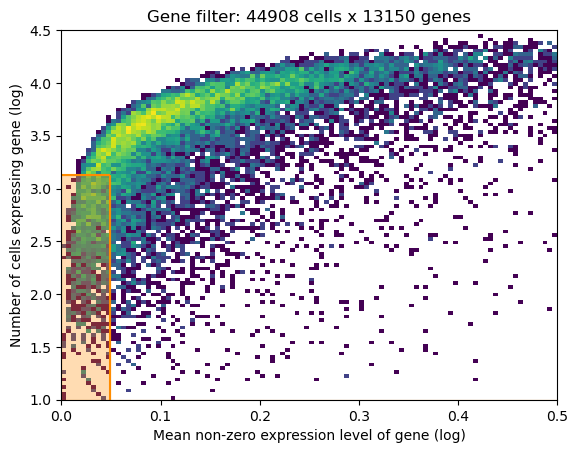

In [36]:
selected_genes = filter_genes(ven_ref_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

In [ ]:
ven_ref_sc = ven_ref_sc[:,ven_ref_sc.var.index.isin(selected_genes)]
print(ven_ref_sc.shape)
ref, mod = train_reference(region_ref=ven_ref_sc,
                           annotation_colname="ann_final",
                           batch_key='study',
                           continuous_covariate_keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                           categorical_covariate_keys=['cells_or_nuclei', 'kit', 'organ_uni'],
                           write_prefix="heart_ven/",
                           cell_number_thres=15)

/lustre/scratch126/cellgen/team205/sl37/conda_envs/cell2loc_env/lib/python3.12/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")


(44908, 13150)
Selected the following celltypes for getting signatures ['myo_cap_ec', 'Epithelial cells', 'Lymphoid cells', 'vCM', 'cap_pc', 'Myeloid cells', 'Fibroblasts', 'art_ec_2', 'ven_ec_1', 'cap_lec', 'smc_pc_intermediate', 'art_ec_1', 'B cells', 'art_smc', 'endocardial_ec']
Construct regression model:


Anndata setup with scvi-tools version 1.1.5.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'study',
│   'labels_key': 'ann_final',
│   'categorical_covariate_keys': ['cells_or_nuclei', 'kit', 'organ_uni'],
│   'continuous_covariate_keys': ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 44908 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   3   │
│         n_labels         │  15   │
│          n_vars          │ 13150 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['study'] │         TS         │          0          │
│                    │ Winkler_et_al_2022 │          1          │
│                    │        hca         │          2          │
│                    │       liver        │          3          │
└────────────────────┴────────────────────┴─────────────────────┘

                        labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['ann_final'] │       B cells       │          0          │
│                        │  Epithelial cells   │          1          │
│                        │     Fibroblasts     │          2          │
│                        │   Lymphoid cells    │          3          │
│                        │    Myeloid cells    │          4          │
│                        │      art_ec_1       │          5          │
│                        │      art_ec_2       │          6          │
│                        │       art_smc       │          7          │
│                        │       cap_lec       │          8          │
│                        │       cap_pc        │          9          │
│                        │   endocardial_ec    │         10          │
│                        │     myo_cap_ec      │         11          │
│                        │ smc_pc_intermediate │         12          │
│                        │         vCM         │         13          │
│                        │      ven_ec_1       │         14          │
└────────────────────────┴─────────────────────┴─────────────────────┘

                 extra_categorical_covs State Registry                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cells_or_nuclei'] │      cell       │          0          │
│                              │     nuclei      │          1          │
│                              │                 │                     │
│       adata.obs['kit']       │       10X       │          0          │
│                              │  10x3prime_v2   │          1          │
│                              │  10x3prime_v3   │          2          │
│                              │    10x5prime    │          3          │
│                              │  10x5prime_v2   │          4          │
│                              │   10x_3prime    │          5          │
│                              │   Multiome-v1   │          6          │
│                              │                 │                     │
│    adata.obs['organ_uni']    │ adipose_tissue  │          0          │
│                              │     bladder     │          1          │
│                              │      brain      │          2          │
│                              │     decidua     │          3          │
│                              │      heart      │          4          │
│                              │     kidney      │          5          │
│                              │ large_intestine │          6          │
│                              │  large_vessels  │          7          │
│                              │      liver      │          8          │
│                              │      lung       │          9          │
│                              │   lymph_node    │         10          │
│                              │     muscle      │         11          │
│                              │   oesophagus    │         12          │
│                              │    pancreas     │         13          │
│                              │ small_intestine │         14          │
│                              │     spleen      │         15          │
│                              │     thymus      │         16          │
│                              │     trachea     │         17          │
│                              │     uterus      │         18          │
│                              │                 │                     │
└──────────────────────────────┴─────────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['n_genes_by_counts'] │
│   adata.obs['total_counts']    │
│   adata.obs['pct_counts_mt']   │
└────────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/scratch126/cellgen/team205/sl37/conda_envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


None
Start training...
Epoch 250/250: 100%|█| 250/250 [08:36<00:00,  2.72s/it, v_num=1, elbo_train=2.55

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█| 250/250 [08:36<00:00,  2.07s/it, v_num=1, elbo_train=2.55
Sampling global variables, sample: 100%|██████| 999/999 [00:18<00:00, 53.69it/s]


# aCM reference

In [ ]:
old_atr_sc = sc.read_h5ad("/nfs/users/nfs_s/sl37/lustre_sl37/vasculature/heart_nomyocytes/heart_atrium/ref.posterior.h5ad")
old_atr_sc[old_atr_sc.obs['cell_or_nuclei'] == 'Nuclei'].obs['compartment_and_celltype'].value_counts()
atr_nuclei_sc = old_atr_sc[old_atr_sc.obs['cell_or_nuclei'] == 'Nuclei']
atr_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'
atr_nuclei_sc.obs['organ_uni'] = 'heart'
atr_nuclei_sc.obs['compartment_and_celltype'].value_counts()
dic = {
    "T_cells/NKs/ILCs": 'Lymphoid cells',
    "Myeloid_cells": 'Myeloid cells',
    "B_cells": "B cells",
    "aCM": 'aCM'
}
atr_nuclei_sc.obs['ann_final'] = [dic.get(x) for x in atr_nuclei_sc.obs['compartment_and_celltype']]
atr_ref_sc = concat(
    [atr_nuclei_sc, heart_raw_sc], 
    merge='same'
)
selected_genes = filter_genes(atr_ref_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

atr_ref_sc = atr_ref_sc[:,atr_ref_sc.var.index.isin(selected_genes)]
print(atr_ref_sc.shape)
ref, mod = train_reference(region_ref=atr_ref_sc,
                           annotation_colname="ann_final",
                           batch_key='study',
                           continuous_covariate_keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                           categorical_covariate_keys=['cells_or_nuclei', 'kit', 'organ_uni'],
                           write_prefix="heart_atrial/",
                           cell_number_thres=15)

# Heart reference

In [12]:
old_ven_sc = sc.read_h5ad("/nfs/users/nfs_s/sl37/lustre_sl37/vasculature/heart_nomyocytes/heart_ventricle/ref.posterior.h5ad")
ven_nuclei_sc = old_ven_sc[old_ven_sc.obs['cell_or_nuclei'] == 'Nuclei']
ven_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'
ven_nuclei_sc.obs['organ_uni'] = 'heart'

dic = {
    "T_cells/NKs/ILCs": 'Lymphoid cells',
    "Myeloid_cells": 'Myeloid cells',
    "B_cells": "B cells",
    "vCM": 'CM'
}
ven_nuclei_sc.obs['ann_final'] = [dic.get(x) for x in ven_nuclei_sc.obs['compartment_and_celltype']]

old_atr_sc = sc.read_h5ad("/nfs/users/nfs_s/sl37/lustre_sl37/vasculature/heart_nomyocytes/heart_atrium/ref.posterior.h5ad")
old_atr_sc[old_atr_sc.obs['cell_or_nuclei'] == 'Nuclei'].obs['compartment_and_celltype'].value_counts()
atr_nuclei_sc = old_atr_sc[old_atr_sc.obs['cell_or_nuclei'] == 'Nuclei']
atr_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'
atr_nuclei_sc.obs['organ_uni'] = 'heart'
atr_nuclei_sc.obs['compartment_and_celltype'].value_counts()
dic = {
    "T_cells/NKs/ILCs": 'Lymphoid cells',
    "Myeloid_cells": 'Myeloid cells',
    "B_cells": "B cells",
    "aCM": 'CM'
}
atr_nuclei_sc.obs['ann_final'] = [dic.get(x) for x in atr_nuclei_sc.obs['compartment_and_celltype']]

/tmp/ipykernel_2258937/2765992686.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ven_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'
/tmp/ipykernel_2258937/2765992686.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atr_nuclei_sc.obs['cells_or_nuclei'] = 'nuclei'


In [13]:
heart_ref_sc = concat(
    [ven_nuclei_sc, atr_nuclei_sc, heart_raw_sc], 
    merge='same'
)

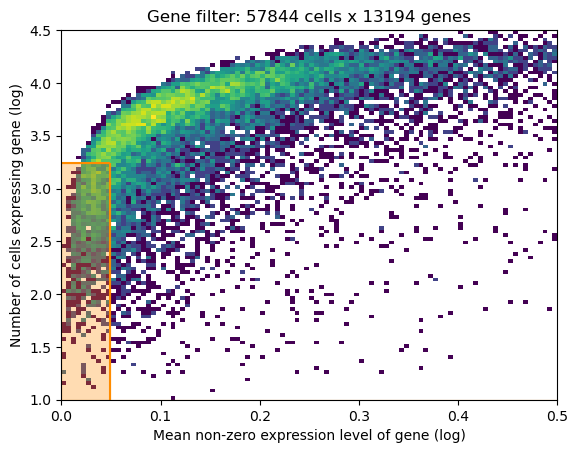

(57844, 13194)
Selected the following celltypes for getting signatures ['Lymphoid cells', 'CM', 'myo_cap_ec', 'Epithelial cells', 'Myeloid cells', 'cap_pc', 'Fibroblasts', 'art_ec_2', 'ven_ec_1', 'cap_lec', 'B cells', 'smc_pc_intermediate', 'art_ec_1', 'art_smc', 'endocardial_ec']


/lustre/scratch126/cellgen/team205/sl37/conda_envs/cell2loc_env/lib/python3.12/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Construct regression model:


Anndata setup with scvi-tools version 1.1.5.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'study',
│   'labels_key': 'ann_final',
│   'categorical_covariate_keys': ['cells_or_nuclei', 'kit', 'organ_uni'],
│   'continuous_covariate_keys': ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 57844 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   3   │
│         n_labels         │  15   │
│          n_vars          │ 13194 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['study'] │         TS         │          0          │
│                    │ Winkler_et_al_2022 │          1          │
│                    │        hca         │          2          │
│                    │       liver        │          3          │
└────────────────────┴────────────────────┴─────────────────────┘

                        labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['ann_final'] │       B cells       │          0          │
│                        │         CM          │          1          │
│                        │  Epithelial cells   │          2          │
│                        │     Fibroblasts     │          3          │
│                        │   Lymphoid cells    │          4          │
│                        │    Myeloid cells    │          5          │
│                        │      art_ec_1       │          6          │
│                        │      art_ec_2       │          7          │
│                        │       art_smc       │          8          │
│                        │       cap_lec       │          9          │
│                        │       cap_pc        │         10          │
│                        │   endocardial_ec    │         11          │
│                        │     myo_cap_ec      │         12          │
│                        │ smc_pc_intermediate │         13          │
│                        │      ven_ec_1       │         14          │
└────────────────────────┴─────────────────────┴─────────────────────┘

                 extra_categorical_covs State Registry                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cells_or_nuclei'] │      cell       │          0          │
│                              │     nuclei      │          1          │
│                              │                 │                     │
│       adata.obs['kit']       │       10X       │          0          │
│                              │  10x3prime_v2   │          1          │
│                              │  10x3prime_v3   │          2          │
│                              │    10x5prime    │          3          │
│                              │  10x5prime_v2   │          4          │
│                              │   10x_3prime    │          5          │
│                              │   Multiome-v1   │          6          │
│                              │                 │                     │
│    adata.obs['organ_uni']    │ adipose_tissue  │          0          │
│                              │     bladder     │          1          │
│                              │      brain      │          2          │
│                              │     decidua     │          3          │
│                              │      heart      │          4          │
│                              │     kidney      │          5          │
│                              │ large_intestine │          6          │
│                              │  large_vessels  │          7          │
│                              │      liver      │          8          │
│                              │      lung       │          9          │
│                              │   lymph_node    │         10          │
│                              │     muscle      │         11          │
│                              │   oesophagus    │         12          │
│                              │    pancreas     │         13          │
│                              │ small_intestine │         14          │
│                              │     spleen      │         15          │
│                              │     thymus      │         16          │
│                              │     trachea     │         17          │
│                              │     uterus      │         18          │
│                              │                 │                     │
└──────────────────────────────┴─────────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['n_genes_by_counts'] │
│   adata.obs['total_counts']    │
│   adata.obs['pct_counts_mt']   │
└────────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


None
Start training...


/lustre/scratch126/cellgen/team205/sl37/conda_envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|███████████████████| 250/250 [12:56<00:00,  3.10s/it, v_num=1, elbo_train=3.08e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Sampling global variables, sample: 100%|███████████████████████████| 999/999 [00:06<00:00, 142.76it/s]
Model saved in. heart_ref//regression_model
Reference data with posterior values saved in  heart_ref//ref.posterior.h5ad


In [14]:
selected_genes = filter_genes(heart_ref_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

heart_ref_sc = heart_ref_sc[:,heart_ref_sc.var.index.isin(selected_genes)]
print(heart_ref_sc.shape)
ref, mod = train_reference(region_ref=heart_ref_sc,
                           annotation_colname="ann_final",
                           batch_key='study',
                           continuous_covariate_keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                           categorical_covariate_keys=['cells_or_nuclei', 'kit', 'organ_uni'],
                           write_prefix="heart_ref/",
                           cell_number_thres=15)

In [15]:
ref.uns['mod']['factor_names']

['B cells',
 'CM',
 'Epithelial cells',
 'Fibroblasts',
 'Lymphoid cells',
 'Myeloid cells',
 'art_ec_1',
 'art_ec_2',
 'art_smc',
 'cap_lec',
 'cap_pc',
 'endocardial_ec',
 'myo_cap_ec',
 'smc_pc_intermediate',
 'ven_ec_1']

# brain

In [44]:
adat[adat.obs['organ_uni']=='brain'].obs['ann_final'].value_counts()

ann_final
Fibroblasts               6453
brain_art_smc             2867
art_smc                   2180
brain_art_ec               419
blood_brain_barrier_ec     368
brain_ven_ec               140
smc_pc_intermediate         47
pul_smc                     16
art_ec_1                    13
cap_pc                       7
aorta_coronary_smc           7
Epithelial cells             6
kidney_art_ec                4
Myeloid cells                3
art_ec_2                     3
ven_ec_1                     2
Littoral_EC                  1
Lymphoid cells               1
myo_cap_ec                   1
endometrium_cap_ec           1
pul_ven_ec                   1
uterine_pc                   1
Name: count, dtype: int64